In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms
from morphology import *

In [2]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import tensorflow as tf



img_path = '/content/tnc_54897705.jpg'
img = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=1):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()

    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities

    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')

print(predicted_classes)
get_class_name(top_classes[0].item())
target_class = top_classes[0].item()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Prediction for class 1 = 0.00%
Top 1 class: tiger shark, Probability: 99.41%
Top 2 class: great white shark, Probability: 0.41%
Top 3 class: hammerhead, Probability: 0.17%
Prediction for class 1 = 0.00%


Buenardo

In [4]:
class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def generate_support_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        support_masks = np.empty((N, *self.input_size))

        for i in range(N):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            support_masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                            anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        support_masks = support_masks.reshape(-1, 1, *self.input_size)
        support_masks = torch.from_numpy(support_masks).float().cuda()
        return support_masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()

        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = 50
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        self.generate_masks(N, s, p1)

        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)

        for i in range(N):
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                #print(f"Generating Mutant Number#{i+1}/ It should be Pass {N}")
            else:
                target_score = threshold
                tag = "Fail"
                #print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            mask = self.masks[i].clone()  # Clone the mask to prevent in-place modifications
            beta = 5
            erosion_count = 0
            dilation_count = 0

            while not found:
                masked_image = torch.mul(mask, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100

                #Si toca Pass, o Fail. Y el mutante milagrosamente funciona en la categoria
                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    #Si el mutante está bueno, y el score es más alto que el threshold
                    if (tag == "Pass") and pred_score >= target_score:
                        found = True
                        best_score = pred_score
                        best_mutant = masked_image
                        sampled_tensor[i] = best_mutant[-1].squeeze(0)
                        scores[i] = best_score
                        self.masks[i] = mask[-1]

                    else:
                        if pred_score < 30:
                            mask = dilation(mask)  # Apply dilation to the cloned mask
                            dilation_count += 1
                            beta += 5
                            if dilation_count >= 15:
                                new_mask = self.generate_support_masks(1, s, p1)
                                beta = 3
                                mask = new_mask
                                dilation_count = 0
                        else:
                          found = True
                          best_score = pred_score
                          best_mutant = masked_image
                          sampled_tensor[i] = best_mutant[-1].squeeze(0)
                          scores[i] = best_score
                          self.masks[i] = mask[-1]

                #Si el mutante no encaja en la categoria
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        mask = dilation(mask)  # Apply dilation to the cloned mask
                        dilation_count += 1
                        beta += 5
                        if dilation_count >= 15:
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            dilation_count = 0
                    else:
                        mask = erosion(mask)  # Apply erosion to the cloned mask
                        erosion_count += 1
                        beta += 5
                        if erosion_count >= 15:
                            #print("Generating another mask because erosion failed")
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            erosion_count = 0  # Reset the erosion count

        masks = self.masks
        return masks, threshold, sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))
N = 500
# Assuming img and target_class are defined
masks, threshold, sampled_tensor, scores = explainer.generate_mutants(img, N, s=5, p1=0.6, target_class=target_class)



Maximum prediction score: 99.40548539161682
Threshold: 50


Generating filters: 100%|██████████| 500/500 [00:01<00:00, 395.28it/s]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed
import torch  # Assuming the mutants tensor is a PyTorch tensor

def visualize_single_mutant(mutants, scores, index):
    """
    Visualize a single mutant image with its score.

    Parameters:
    - mutants: Tensor of mutant images.
    - scores: List or array of scores corresponding to the mutant images.
    - index: Index of the mutant image to visualize.
    """
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{scores[index]:.2f}%")
    plt.axis('off')
    plt.show()

# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant,
         mutants=fixed(sampled_tensor),
         scores=fixed(scores),
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=499), Output()), _dom_classes=('widg…

In [6]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
def unnormalize(tensor, mean, std):
    """
    Unnormalizes a tensor using the specified mean and std.
    """
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

def rgb_to_grayscale(tensor):
    """
    Converts RGB images to grayscale by applying the standard luminosity method.
    """
    r, g, b = tensor[:, 0, :, :], tensor[:, 1, :, :], tensor[:, 2, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Maintain the batch and channel dimension

mean = [0.485, 0.456, 0.406]  # ImageNet mean
std = [0.229, 0.224, 0.225]   # ImageNet std
sampled_tensor = unnormalize(sampled_tensor, mean, std)
#sampled_tensor = TF.rgb_to_grayscale(sampled_tensor)


# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant,
         mutants=fixed(sampled_tensor),
         scores=fixed(scores),
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

# Convert scores to a PyTorch tensor
scores_tensor = torch.tensor(scores, dtype=torch.float32)

# Perform the division
scores_tensor = scores_tensor / 100

# Convert the tensor back to a list
scores_list = scores_tensor.tolist()



sampled_tensor.shape
img = unnormalize(img, mean, std)
img = TF.rgb_to_grayscale(img)
img = img.repeat(N, 1, 1, 1)
print(img.shape)

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=499), Output()), _dom_classes=('widg…

torch.Size([500, 1, 224, 224])


In [7]:
def calculate_relevance_scores(sampled_tensor, mask, N, scores, threshold, device='cuda'):
    threshold = threshold/100
    sampled_tensor = sampled_tensor.to(device)
    scores = torch.tensor(scores, device=device)
    _, C, H, W = sampled_tensor.shape
    scores_reshaped = scores.view(-1, 1, 1, 1)
    DX = N / 2

    new_shape = [N] * N

# Create a new tensor with the required shape, where each dimension is filled with its respective value
    #scores_expanded = scores.view(-1, *([1] * (N - 1))).expand(new_shape)
    pass_indices = scores > threshold
    fail_indices = scores <= threshold
    shape = (N, 1, 224, 224)
    tensor_ones = torch.ones(shape).to(device)
    reverse_mask = tensor_ones - mask
    executed_tensors = tensor_ones * mask
    not_executed_tensors = tensor_ones * reverse_mask

    e_pass_tensors = executed_tensors[pass_indices] / DX
    e_fail_tensors = executed_tensors[fail_indices] / DX

    n_pass_tensors = not_executed_tensors[pass_indices] / DX
    n_fail_tensors = not_executed_tensors[fail_indices] / DX


    Ep = e_pass_tensors.sum(dim=0)
    Ef = e_fail_tensors.sum(dim=0)
    Np = n_pass_tensors.sum(dim=0)
    Nf = n_fail_tensors.sum(dim=0)

    return Ep, Ef, Np, Nf

def calculate_ochiai(Ep, Np, Ef, Nf):
    return Ef / torch.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(Ep, Np, Ef, Nf):
    return (Ef / (Ef + Nf)) / ((Ef / (Ef + Nf)) + (Ep / (Ep + Np)))

def calculate_zoltar(Ep, Np, Ef, Nf):
    return Ef / (Ef + Nf + Ep + ((10000 * Nf * Ep) / Ef))

def calculate_wong1(Ep, Np, Ef, Nf):
    return Ef - Ep

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

# Assuming img, masks, N, scores, and threshold are defined
Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N, scores_list, threshold)

# Calculate scores directly on tensors
ochiai_scores = calculate_ochiai(Ep, Np, Ef, Nf)
tarantula_scores = calculate_tarantula(Ep, Np, Ef, Nf)
zoltar_scores = calculate_zoltar(Ep, Np, Ef, Nf)
wong1_scores = calculate_wong1(Ep, Np, Ef, Nf)

# Map values to range if necessary
mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarantula_scores = map_values_to_range(tarantula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)





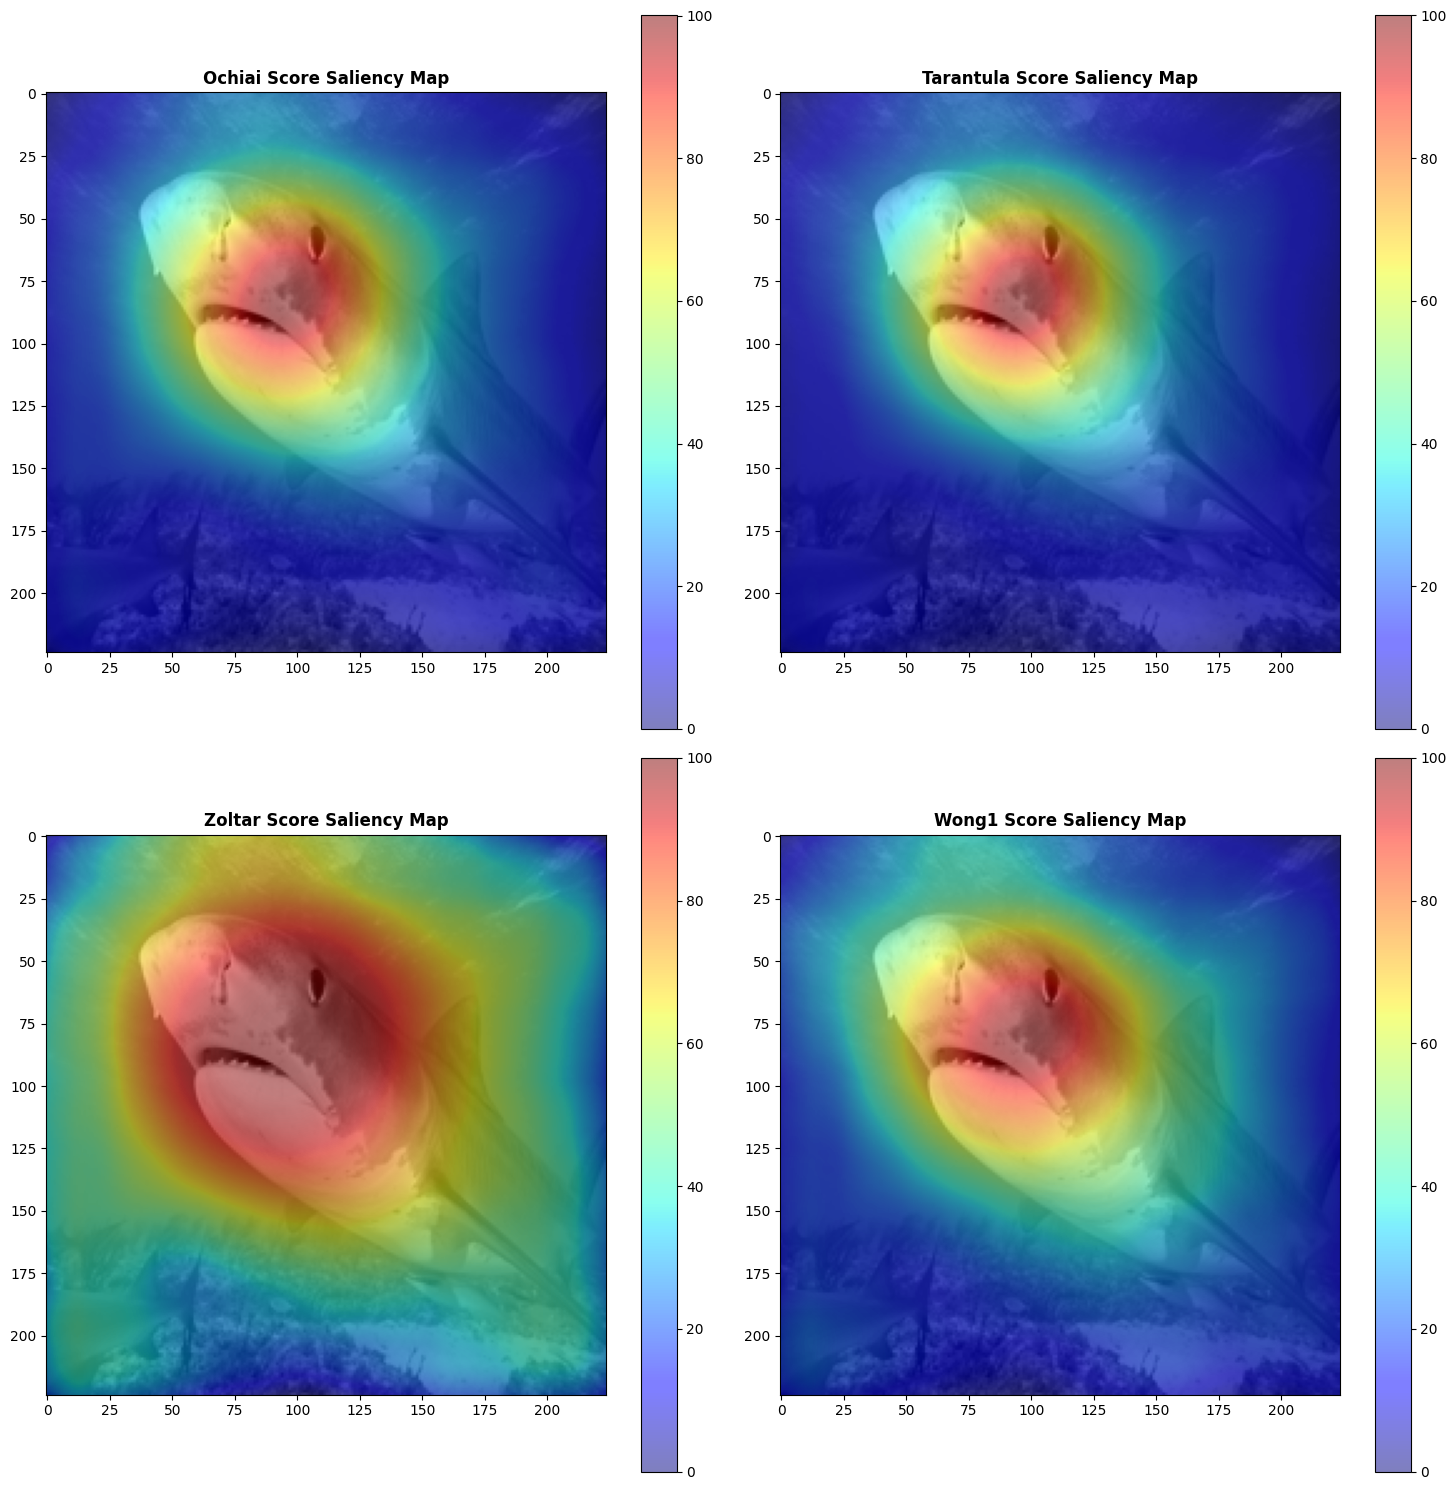

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Convert to numpy arrays by moving tensors to CPU first
mapped_ochiai_scores_np = mapped_ochiai_scores.cpu().detach().numpy()
mapped_tarantula_scores_np = mapped_tarantula_scores.cpu().detach().numpy()
mapped_zoltar_scores_np = mapped_zoltar_scores.cpu().detach().numpy()
mapped_wong1_scores_np = mapped_wong1_scores.cpu().detach().numpy()

original_image_array = np.array(original_image)

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores_np.reshape((224, 224))
tarantula_map = mapped_tarantula_scores_np.reshape((224, 224))
zoltar_map = mapped_zoltar_scores_np.reshape((224, 224))
wong1_map = mapped_wong1_scores_np.reshape((224, 224))

ochiai_map = ochiai_map.max() - ochiai_map
tarantula_map = tarantula_map.max() - tarantula_map
zoltar_map = zoltar_map.max() - zoltar_map
wong1_map = wong1_map.max() - wong1_map

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')

    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

    # Add a colorbar
    fig.colorbar(c, ax=ax)

    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


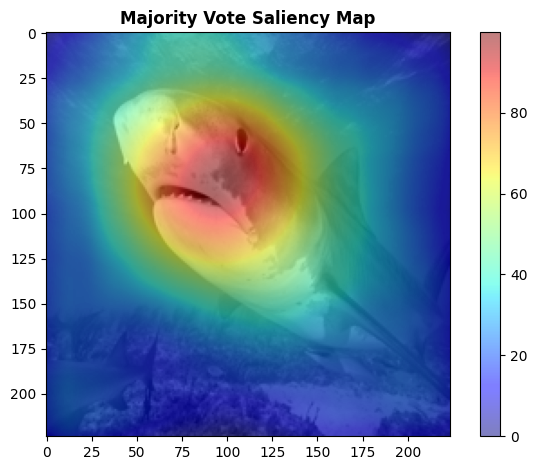

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)



# Define the extent
extent = [0, 224, 0, 224]

# Plot each map

# Stack the scores for majority voting
all_scores = np.stack((ochiai_map, tarantula_map, zoltar_map, wong1_map), axis=-1)

# Function to get majority vote
def majority_vote(scores):
    return np.average(scores)

# Apply majority voting
majority_scores = np.apply_along_axis(majority_vote, 2, all_scores)

# Reshape the majority scores to match the original image dimensions (not needed if already correct)
saliency_map = majority_scores

# Plot the majority vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()



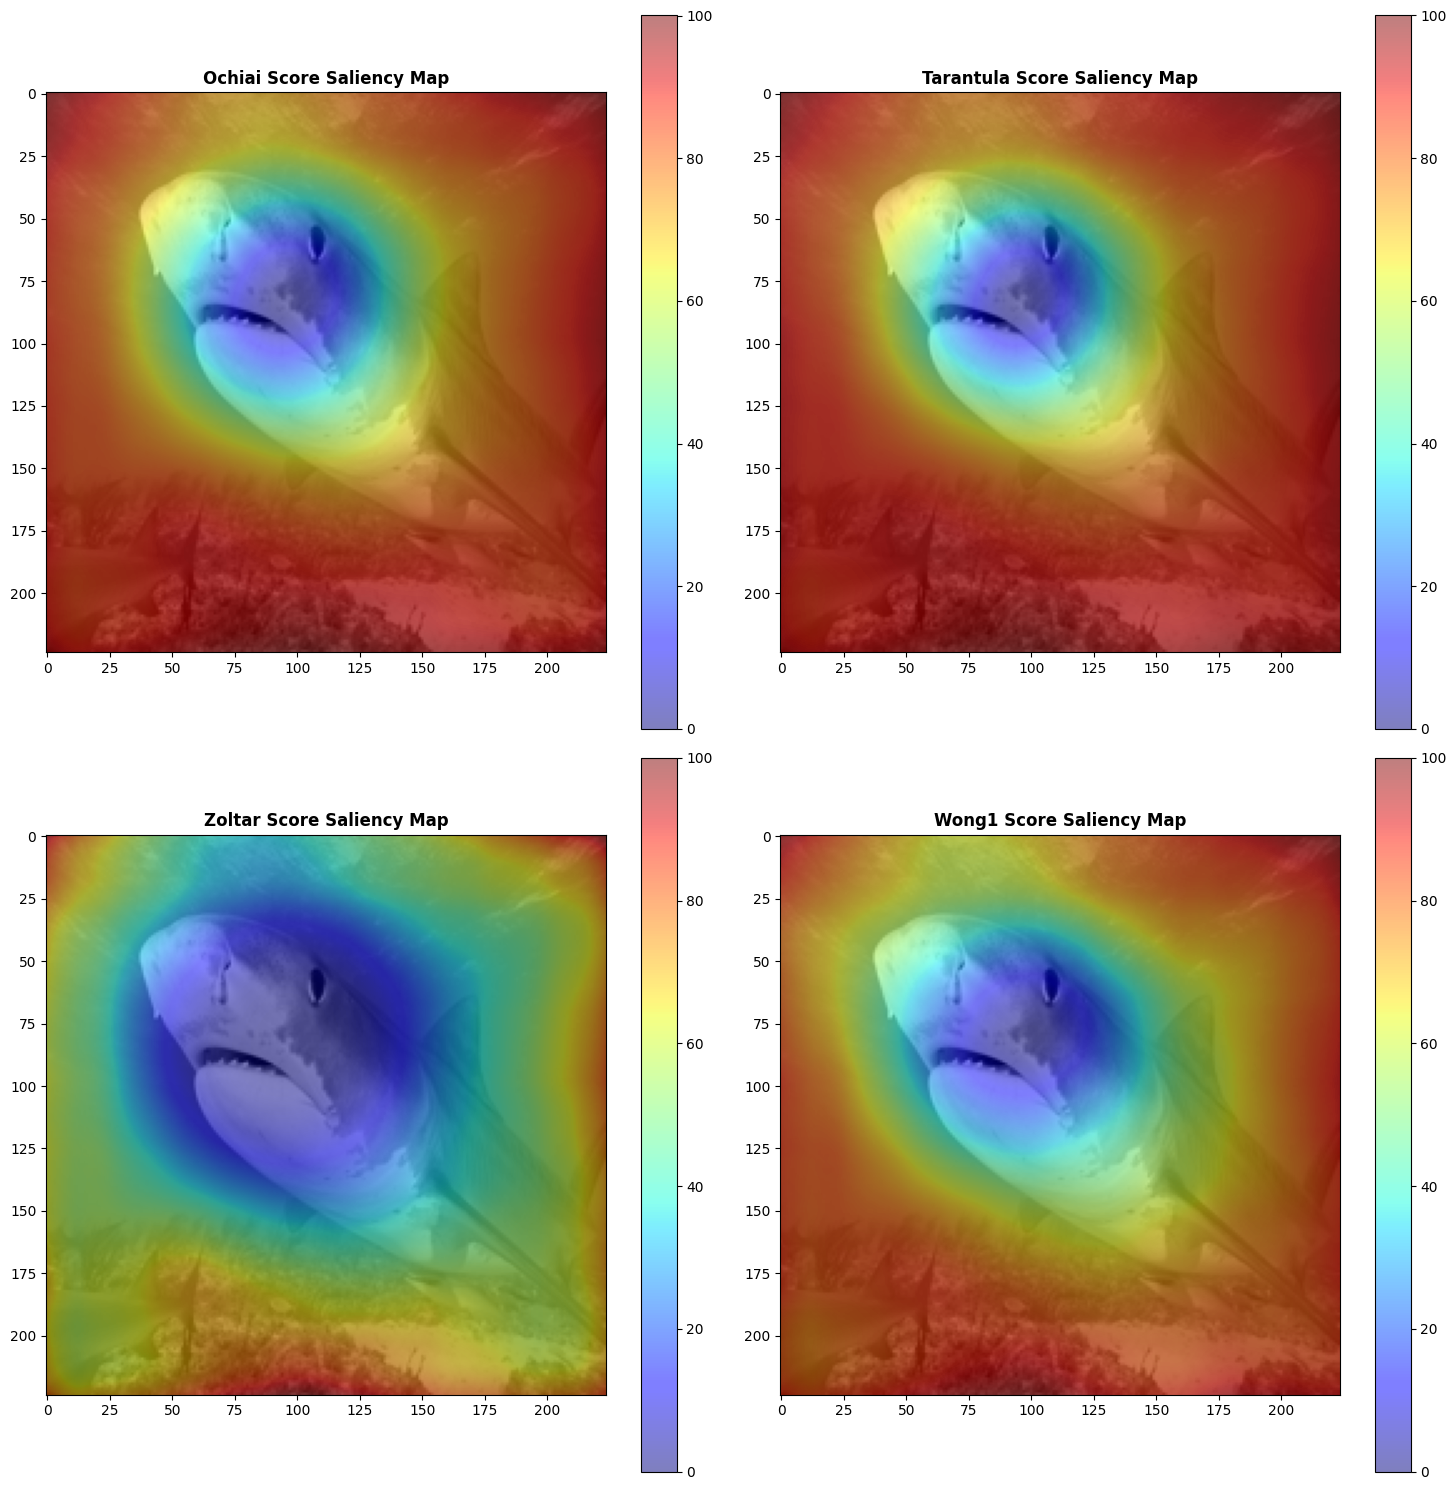

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Ensure to move tensors to CPU and then convert to numpy arrays
mapped_ochiai_scores_np = mapped_ochiai_scores.cpu().detach().numpy()
mapped_tarantula_scores_np = mapped_tarantula_scores.cpu().detach().numpy()
mapped_zoltar_scores_np = mapped_zoltar_scores.cpu().detach().numpy()
mapped_wong1_scores_np = mapped_wong1_scores.cpu().detach().numpy()

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores_np.reshape((224, 224))
tarantula_map = mapped_tarantula_scores_np.reshape((224, 224))
zoltar_map = mapped_zoltar_scores_np.reshape((224, 224))
wong1_map = mapped_wong1_scores_np.reshape((224, 224))

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')

    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

    # Add a colorbar
    fig.colorbar(c, ax=ax)

    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps and invert their values
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarauntula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Invert the values by subtracting from the max value of each map
ochiai_map = ochiai_map.max() - ochiai_map
tarantula_map = tarantula_map.max() - tarantula_map
zoltar_map = zoltar_map.max() - zoltar_map
wong1_map = wong1_map.max() - wong1_map

# Stack the scores for majority voting
all_scores = np.stack((ochiai_map, tarantula_map, zoltar_map, wong1_map), axis=-1)

# Function to apply the custom majority voting logic with weighted sum
def custom_majority_vote(scores):
    # Check if any score is below 20 (high relevance for low scores)
    if np.any(scores < 20):
        weights = np.where(scores < 20, 2, 1)  # Apply higher weight to low scores
        return np.sum(scores * weights) / np.sum(weights)
    # Check if all scores are in the range of 80 to 100, apply weighted sum
    elif np.all(scores >= 80) and np.all(scores <= 100):
        weights = np.where((scores >= 80) & (scores <= 100), 2, 1)  # Apply higher weight to high scores
        return np.sum(scores * weights) / np.sum(weights)
    # Otherwise, use the average of the scores
    else:
        return np.average(scores)

# Apply custom majority voting
custom_scores = np.apply_along_axis(custom_majority_vote, 2, all_scores)

# Reshape the custom scores to match the original image dimensions (not needed if already correct)
saliency_map = custom_scores

# Plot the custom saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Custom Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'mapped_tarauntula_scores' is not defined